## Train

In [33]:
from keras.applications.mobilenet_v2 import MobileNetV2 
from keras.applications.mobilenet import MobileNet
from keras.applications.densenet import DenseNet169
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetMobile, NASNetLarge
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
# from SmallerVGGNet.smallervggnet import SmallerVGGNet
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam, SGD, Adagrad, Adadelta
from keras import backend as K
from imutils import paths
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import random
import pickle
import cv2
import os

%matplotlib inline

In [4]:
# specify data folder name, model name and label file name
args = {"dataset":"dataset", "model":"spider.model", "labelbin":"lb.pickle"}

In [5]:
# initialize the number of epochs to train for, initial learning rate, batch size, and image dimensions
EPOCHS = 50
INIT_LR = 0.001
BS = 32

# image dimension may need to change according to the model spec

# IMAGE_DIMS = (96, 96, 3)
IMAGE_DIMS =  (224, 224, 3)

In [6]:
# initialize the data and labels
data = []
labels = []

In [7]:
# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images(args["dataset"])))
random.seed(0)
random.shuffle(imagePaths)

In [8]:
# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    assert os.path.isfile(imagePath)
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)

    # extract the class label from the image path and update the labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

In [9]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("data matrix: {:.2f}MB".format(data.nbytes / (1024 * 1000.0)))

# binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# partition the data into training and testing splits using 75% of the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, random_state=0, stratify=labels)

data matrix: 987.84MB


In [10]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, height_shift_range=0.1, 
                         shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

In [11]:
# initialize a custom model from file
# model = SmallerVGGNet.build(height=IMAGE_DIMS[0], width=IMAGE_DIMS[1], depth=IMAGE_DIMS[2], classes=len(lb.classes_), INIT_LR=INIT_LR, EPOCHS=EPOCHS)

In [12]:
# model.summary()

In [ ]:
# experimenting with different learning rate
def lr_experiment():
    
    history = []
    
    for lr in [0.1, 0.01, 0.001]:
        input_tensor = Input(shape=IMAGE_DIMS)
        base_model = MobileNetV2(
                include_top=False,
                weights='imagenet',
                input_tensor=input_tensor,
                input_shape=IMAGE_DIMS,
                pooling='avg')
        output_tensor = Dense(9, activation='softmax')(base_model.output)
        model = Model(inputs=input_tensor, outputs=output_tensor)
        model.compile(SGD(lr=lr), loss="categorical_crossentropy", metrics=['accuracy', 'top_k_categorical_accuracy'])
        h = model.fit_generator(
                aug.flow(trainX, trainY, batch_size=BS),
                validation_data=(testX, testY),
                steps_per_epoch=len(trainX) // BS,
                epochs=EPOCHS, verbose=1)
        history.append(h)
    
    return history

history = lr_experiment()

In [ ]:
# experimenting with different batch size
def bs_experiment():
    
    history = []
    
    for BS in [64, 32, 16, 4]:
        input_tensor = Input(shape=IMAGE_DIMS)
        base_model = MobileNetV2(
                include_top=False,
                weights='imagenet',
                input_tensor=input_tensor,
                input_shape=IMAGE_DIMS,
                pooling='avg')
        output_tensor = Dense(9, activation='softmax')(base_model.output)
        model = Model(inputs=input_tensor, outputs=output_tensor)
        model.compile(SGD(), loss="categorical_crossentropy", metrics=['accuracy', 'top_k_categorical_accuracy'])
        h = model.fit_generator(
                aug.flow(trainX, trainY, batch_size=BS),
                validation_data=(testX, testY),
                steps_per_epoch=len(trainX) // BS,
                epochs=EPOCHS, verbose=1)
        history.append(h)
    
    return history

history = bs_experiment()

In [29]:
def train():
   
    # create a custom input layer that accepts images of shape IMAGE_DIMS
    input_tensor = Input(shape=IMAGE_DIMS)
    
    # grab the Keras built-in model for transfer learning
    base_model = MobileNetV2(
            include_top=False,
            weights='imagenet',
            input_tensor=input_tensor,
            input_shape=IMAGE_DIMS,
            pooling='avg')
    
    # original model is trained on different dataset with different number of classes
    # so we need to append our own output layer
    output_tensor = Dense(9, activation='softmax')(base_model.output)
    
    model = Model(inputs=input_tensor, outputs=output_tensor)
    
    model.compile(Adam(lr=1e-4), loss="categorical_crossentropy", metrics=['accuracy', 'top_k_categorical_accuracy'])
    
    h = model.fit_generator(
            aug.flow(trainX, trainY, batch_size=BS),
            validation_data=(testX, testY),
            steps_per_epoch=len(trainX) // BS,
            epochs=50, verbose=1)
    
#         Y_test = np.argmax(testY, axis=1) # Convert one-hot to index
#         y_pred = model.predict(testX)
#         # print(y_pred)
#         y_pred = np.argmax(y_pred, axis=1)
#         print(classification_report(Y_test, y_pred, target_names=list(lb.classes_)))

    return h, model

history, model = train()

Epoch 1/50
19/19 [==============================] - 13s 702ms/step - loss: 1.8286 - acc: 0.3931 - top_k_categorical_accuracy: 0.7714 - val_loss: 1.2111 - val_acc: 0.6048 - val_top_k_categorical_accuracy: 0.9143
Epoch 2/50
19/19 [==============================] - 5s 272ms/step - loss: 0.8563 - acc: 0.7568 - top_k_categorical_accuracy: 0.9645 - val_loss: 0.7831 - val_acc: 0.7714 - val_top_k_categorical_accuracy: 0.9810
Epoch 3/50
19/19 [==============================] - 5s 273ms/step - loss: 0.4657 - acc: 0.8817 - top_k_categorical_accuracy: 0.9984 - val_loss: 0.6029 - val_acc: 0.8000 - val_top_k_categorical_accuracy: 0.9952
Epoch 4/50
19/19 [==============================] - 5s 270ms/step - loss: 0.2792 - acc: 0.9327 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.5080 - val_acc: 0.8333 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/50
19/19 [==============================] - 5s 270ms/step - loss: 0.2172 - acc: 0.9532 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4637 - val_ac

Epoch 40/50
19/19 [==============================] - 6s 302ms/step - loss: 0.0052 - acc: 1.0000 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4325 - val_acc: 0.8762 - val_top_k_categorical_accuracy: 0.9905
Epoch 41/50
19/19 [==============================] - 6s 324ms/step - loss: 0.0065 - acc: 0.9984 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4593 - val_acc: 0.8857 - val_top_k_categorical_accuracy: 0.9905
Epoch 42/50
19/19 [==============================] - 6s 306ms/step - loss: 0.0085 - acc: 0.9984 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4265 - val_acc: 0.8952 - val_top_k_categorical_accuracy: 0.9905
Epoch 43/50
19/19 [==============================] - 6s 316ms/step - loss: 0.0060 - acc: 1.0000 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4246 - val_acc: 0.9000 - val_top_k_categorical_accuracy: 0.9905
Epoch 44/50
19/19 [==============================] - 7s 382ms/step - loss: 0.0085 - acc: 0.9984 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4297 - va

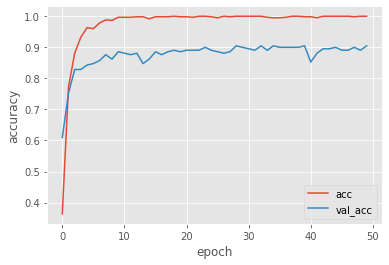

In [17]:
# Plot training & validation accuracy values
plt.style.use("ggplot")
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='lower right')
plt.show()

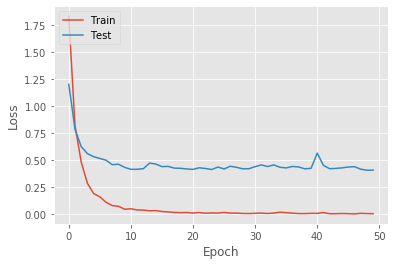

In [19]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# save the model to disk
model.save(args["model"])

In [21]:
# save the label binarizer to disk
f = open(args["labelbin"], "wb")
f.write(pickle.dumps(lb))
f.close()

## Classify

In [27]:
# load the trained convolutional neural network and the label binarizer
# model = load_model(args["model"])
lb = pickle.loads(open(args["labelbin"], "rb").read())

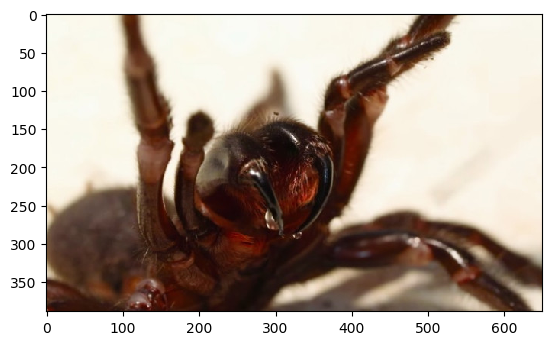

Funnel-Web Spider


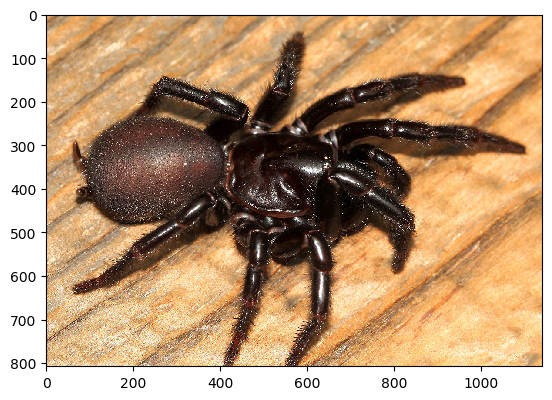

Funnel-Web Spider


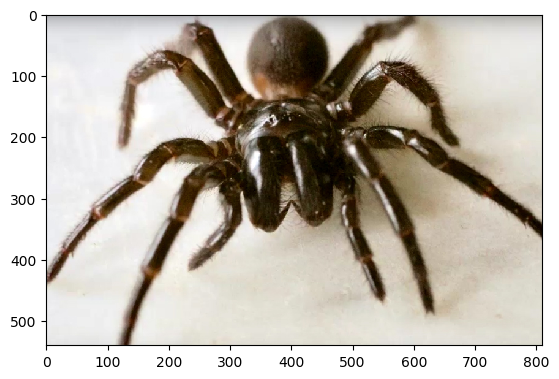

Funnel-Web Spider


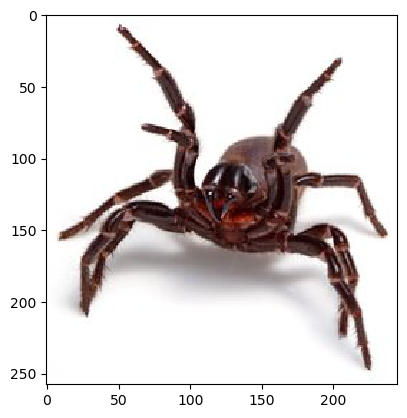

Funnel-Web Spider


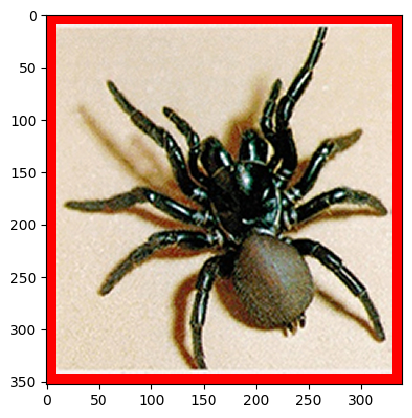

Funnel-Web Spider


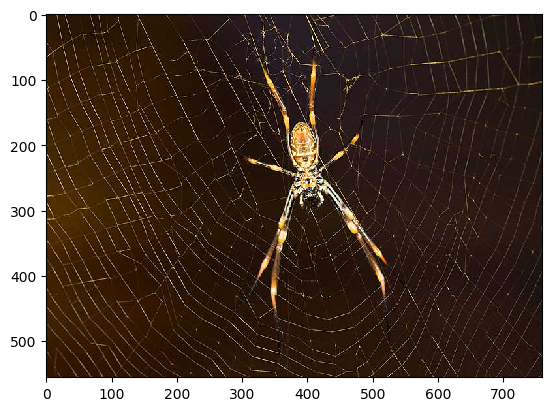

Garden Orb Weaver Spider


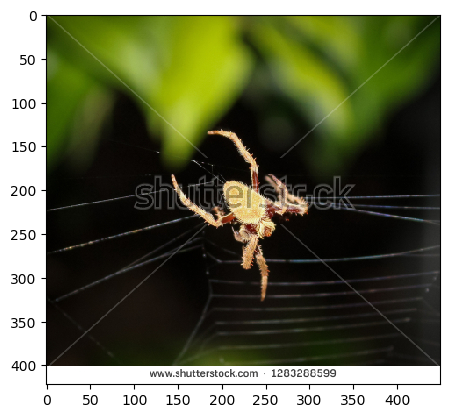

Garden Orb Weaver Spider


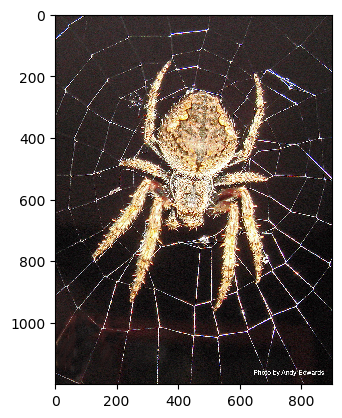

Garden Orb Weaver Spider


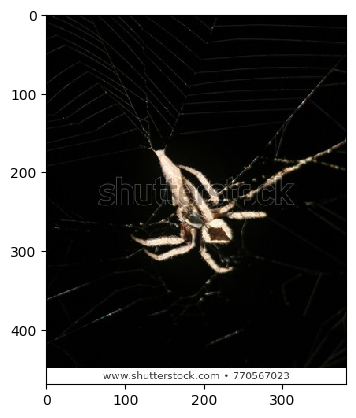

Garden Orb Weaver Spider


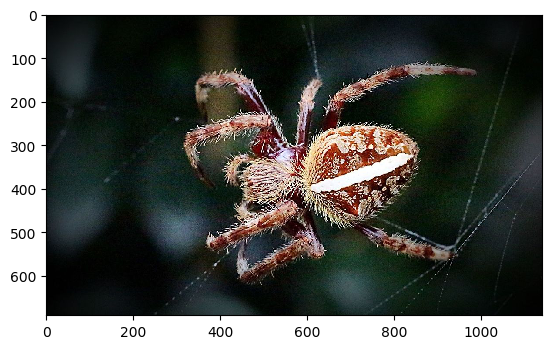

Garden Orb Weaver Spider


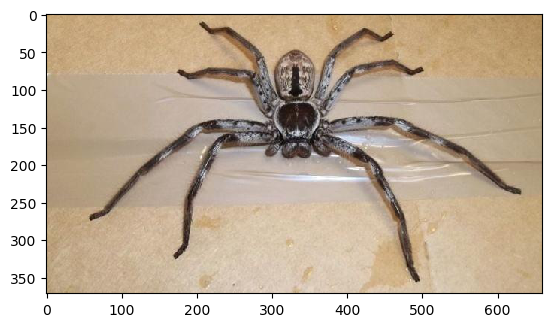

Huntsman Spider


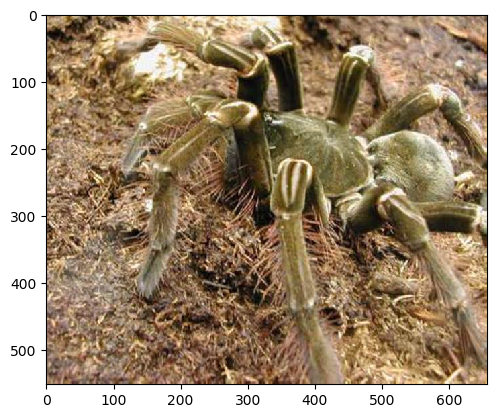

Tarantula Spider


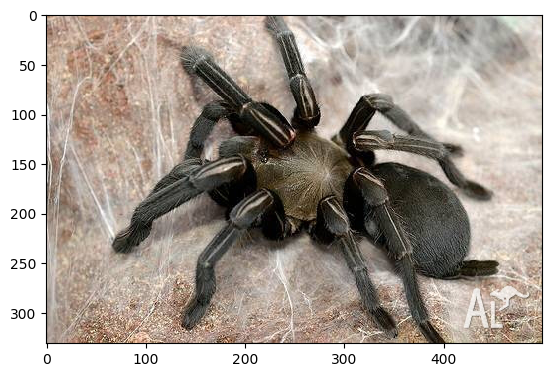

Tarantula Spider


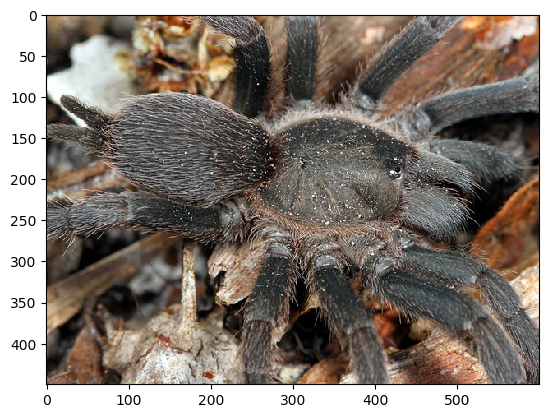

Tarantula Spider


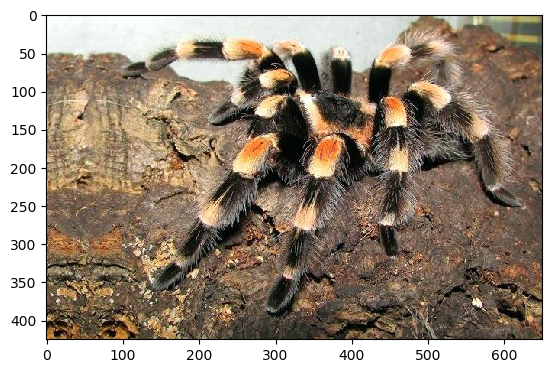

Tarantula Spider


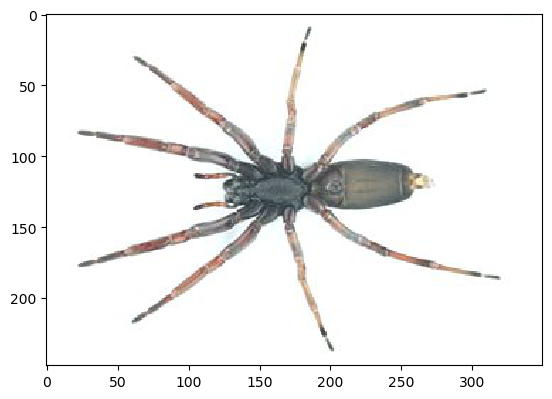

White-Tailed Spider


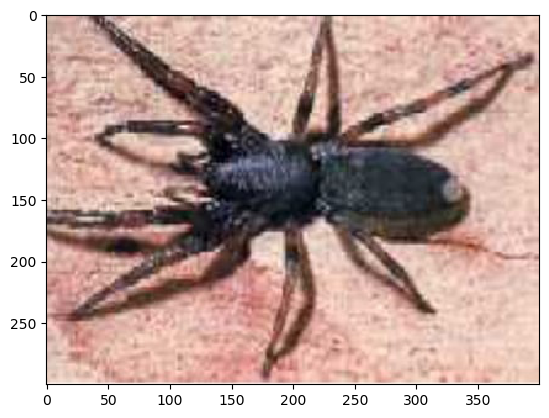

White-Tailed Spider


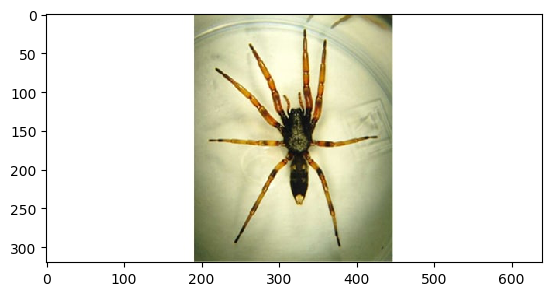

St Andrews Cross Spider


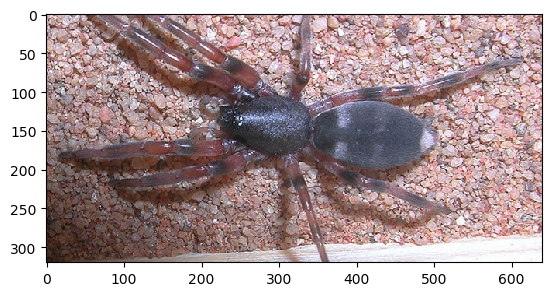

White-Tailed Spider


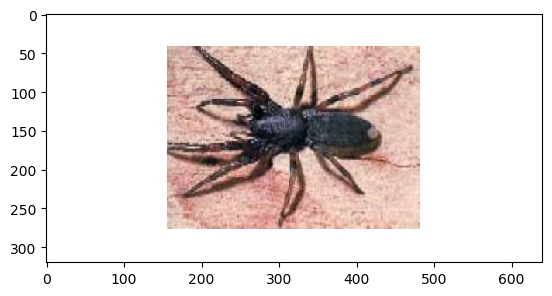

White-Tailed Spider


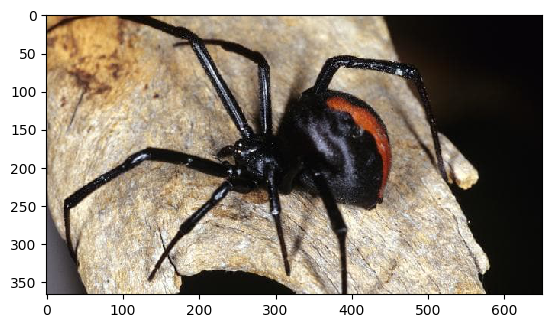

Redback Spider


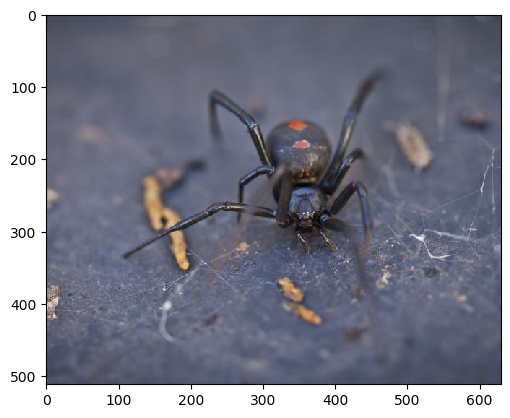

Redback Spider


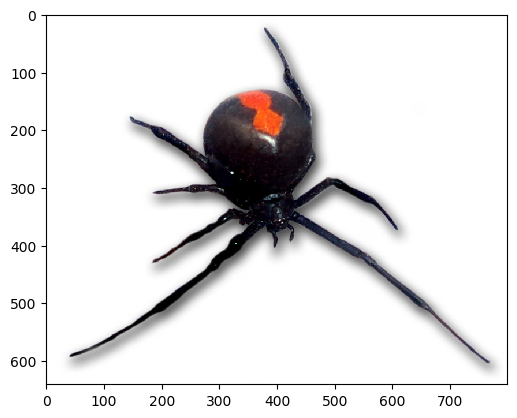

Redback Spider


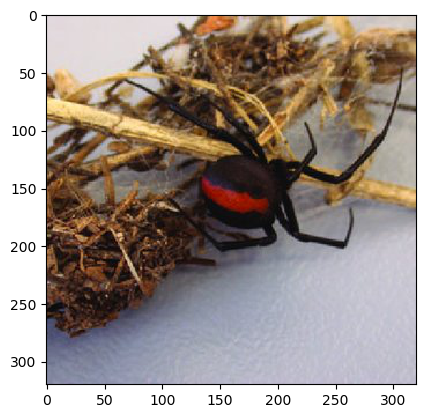

Red-Headed Mouse Spider


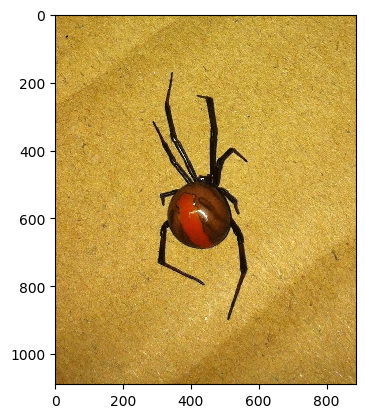

Redback Spider


In [37]:
imagePaths = sorted(list(paths.list_images("test")))
plt.style.use("default")
for x in imagePaths:
    # load the image
    image = cv2.imread(x)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    output = image.copy()

    # pre-process the image for classification
    # image = cv2.resize(image, (96, 96))
    image = cv2.resize(image, (224, 224))

    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    
    # classify the input image
    proba = model.predict(image)[0]
    idx = np.argmax(proba)
    label = lb.classes_[idx]
    print(label)